In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
datacsv          = "Chuck July15/"
list_csv         = os.listdir(datacsv)

In [3]:
baseline = pd.read_csv(datacsv+"Unrestricted_01_20160714_01.csv")
baseline.index = baseline.O.astype(str)+'_'+baseline.D.astype(str)

In [4]:
countrydata = pd.read_csv(datacsv+"Mozambique_OD_locations_20160527_01.csv")

In [5]:
countrydata.head()

,INDEX_OD,INDEX_previous,OD_type,Name,LATITUDE,LONGITUDE,Road_processed,Has_no_road
0,0,0,text,text,-0.550000,-0.550000,NaN,NaN
1,1,1,seaport,BEIRA,-19.833333,34.833333,1,NaN
2,2,5,seaport,MAPUTO,-25.966667,32.583333,1,NaN
3,3,8,seaport,NACALA,-14.533333,40.666667,1,NaN
4,4,10,seaport,PEMBA,-12.966667,40.500000,1,NaN


In [6]:
baseline.head()

,O,D,Total_RUC,Total_Length,Total_Travel_time
1_1,1,1,0.000000,0.000000,0.000000
1_67,1,67,0.994195,2.768213,0.095456
1_9,1,9,2.193483,12.004232,0.401065
1_64,1,64,3.956198,200.752788,2.126615
1_52,1,52,5.932823,288.933716,2.992636


In [23]:
costs_all = pd.DataFrame(columns=["scenarioID","road_index","missingroutes",\
                           "num_aff_routes","ruc_diff","time_diff","km_diff"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "Mozambique" in file:
        continue
    if "Unrestricted" in file:
        continue
    scenar = pd.read_csv(datacsv+file)
    n    = (re.search('Restrict_(.*)_(.*)_01_20160714_01.csv', file).group(1))
    road = (re.search('Restrict_(.*)_(.*)_01_20160714_01.csv', file).group(2))
    scenar.index = scenar.O.astype(str)+'_'+scenar.D.astype(str)
    scenar['weights']=1

    missingroutes = len(baseline)-len(scenar)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.Total_RUC/baseline_nm.Total_RUC,3)!=1)&(baseline_nm.Total_RUC>0)
    if sum(affected_routes)==0:
        costs_all.loc[len(costs_all),:] = [n,road,missingroutes,sum(affected_routes),\
                                           0,0,0]
    else:
    
        subscenar = scenar.ix[affected_routes,:]

        #traffic = info_links.ix[eval("cluster_"+n).ScenarioID,"TPDA"].max()

        diff_ruc_baseline   = (subscenar.Total_RUC-\
                               baseline_nm.ix[affected_routes,"Total_RUC"])
        diff_time_baseline   = (subscenar.Total_Travel_time-\
                               baseline_nm.ix[affected_routes,"Total_Travel_time"])
        diff_km_baseline = (subscenar.Total_Length-baseline_nm.ix[affected_routes,"Total_Length"])
        #diff_tot_baseline   = (traffic*diff_ruc_baseline)

        ruc_diff  = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
        time_diff = np.sum(diff_time_baseline*subscenar.weights)/subscenar.weights.sum()
        km_diff   = np.sum(diff_km_baseline*subscenar.weights)/subscenar.weights.sum()
        #cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

        costs_all.loc[len(costs_all),:] = [n,road,missingroutes,sum(affected_routes),\
                                           ruc_diff,time_diff,km_diff]

In [24]:
costs_all[["missingroutes","num_aff_routes","ruc_diff","time_diff","km_diff"]].astype(float).describe()

,missingroutes,num_aff_routes,ruc_diff,time_diff,km_diff
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,184.285714,395.428571,0.457366,1.435242,28.565138
std,255.655847,463.975748,0.488951,1.730854,42.493088
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,269.000000,0.434396,0.310932,8.331703
75%,260.000000,709.000000,0.846181,3.235288,43.939387
max,768.000000,1468.000000,1.411903,4.007417,155.218309


In [25]:
len(baseline)

17167

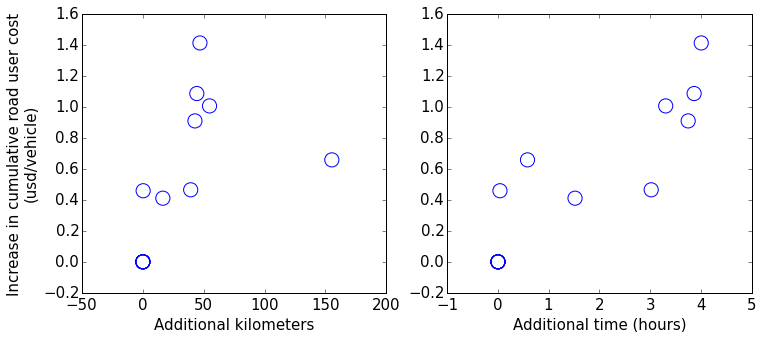

In [19]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(costs_all.km_diff.astype(float), costs_all.ruc_diff.astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost\n(usd/vehicle)")

plt.subplot(122)
plt.scatter(costs_all.time_diff.astype(float), costs_all.ruc_diff.astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional time (hours)")


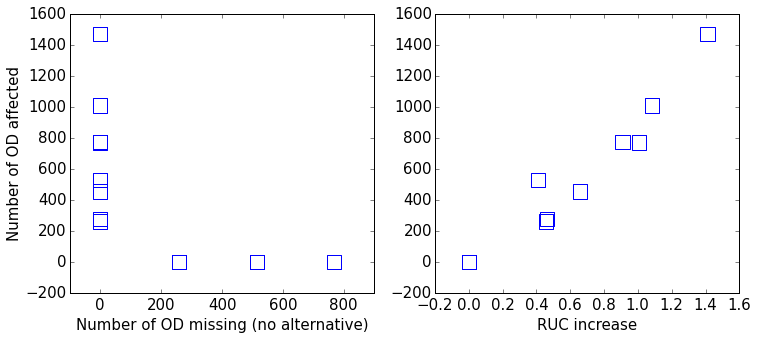

In [17]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(costs_all.missingroutes.astype(float), costs_all.num_aff_routes.astype(float),\
           s=200, alpha=1, marker='s',facecolors='none',edgecolors='blue')
plt.xlabel("Number of OD missing (no alternative)")
plt.ylabel("Number of OD affected")

plt.subplot(122)
plt.scatter(costs_all.ruc_diff.astype(float),costs_all.num_aff_routes.astype(float),\
           s=200, alpha=1, marker='s',facecolors='none',edgecolors='blue')
plt.xlabel("RUC increase")


In [26]:
costs_all.ix[costs_all.missingroutes>0,:]

,scenarioID,road_index,missingroutes,num_aff_routes,ruc_diff,time_diff,km_diff
2,03,0342,516,0,0,0,0
3,04,0605,768,0,0,0,0
4,05,0750,516,0,0,0,0
5,06,0761,260,0,0,0,0
7,08,0751,260,0,0,0,0
9,10,0498,260,0,0,0,0


In [27]:
costs_all.ix[costs_all.num_aff_routes>0,:]

,scenarioID,road_index,missingroutes,num_aff_routes,ruc_diff,time_diff,km_diff
0,01,0494,0,1468,1.411903,4.007417,46.8793
1,02,0684,0,1008,1.085608,3.866992,44.32599
6,07,0509,0,278,0.4645019,3.020894,39.28322
8,09,0310,0,260,0.4584073,0.0395953,0.2391698
10,11,0499,0,772,0.9090389,3.749922,42.77957
11,12,0630,0,454,0.6576078,0.5822678,155.2183
12,13,0130,0,770,1.005679,3.306753,54.76213
13,14,0311,0,526,0.4103841,1.519541,16.42424
